In [7]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [5]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [6]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [7]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0001])
    opt.set_upper_bounds([0.1])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return(res[0])

In [8]:
def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [9]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [10]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [11]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [37]:
def find_max_like_group_ind(numberChromosomes):
    autoNames = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19']
    dfListAuto = [ df.loc[(df['chrom']== x) & (df['distances']>=100)] for x in autoNames[0:numberChromosomes]]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromosomes)]+ [0.0001 for x in range(numberChromosomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromosomes)]+[0.1 for x in range(numberChromosomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromosomes)]+[0.001 for x in range(numberChromosomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromosomes+numberChromosomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromosomes))

    res = opt.optimize(startPoints)
    return(res)

In [13]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['name'].unique())
    test = test.groupby(['distances'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,1,2,3,7]].to_numpy())
    #return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [14]:
df = pd.read_csv('mathematicaInputMice_unbinned.tsv',delimiter='\t')

In [15]:
df

,name,chrom,distances,no_het_bins,one_het_bins,two_het_bins,H0Prop,H1Prop,H2Prop,H
0,H12,chr1,1,62864864,844714.0,13604,0.986531,0.013256,0.000213,0.006841
1,H12,chr1,2,62850711,854466.0,8706,0.986452,0.013411,0.000137,0.006842
2,H12,chr1,3,62840557,856190.0,7807,0.986437,0.013440,0.000123,0.006843
3,H12,chr1,4,62831402,855898.0,7907,0.986438,0.013437,0.000124,0.006843
4,H12,chr1,5,62821707,856675.0,7467,0.986431,0.013452,0.000117,0.006843
...,...,...,...,...,...,...,...,...,...,...
199995,H36,chrX,996,33330821,249597.0,673,0.992547,0.007433,0.000020,0.003736
199996,H36,chrX,997,33326448,249349.0,779,0.992551,0.007426,0.000023,0.003736
199997,H36,chrX,998,33321896,249468.0,706,0.992548,0.007431,0.000021,0.003736
199998,H36,chrX,999,33317379,249504.0,668,0.992547,0.007433,0.000020,0.003736


In [38]:
coEstimatesAutosomes = find_max_like_group_ind(19)
coEstimatesAutosomes

array([1.45756486e-03, 1.80727905e-03, 1.86536342e-03, 1.61298296e-03,
       1.94717866e-03, 1.70580009e-03, 1.67423386e-03, 2.31523980e-03,
       1.73683272e-03, 1.96466475e-03, 1.74678502e-03, 1.75203665e-03,
       1.89861553e-03, 1.92549761e-03, 1.60604398e-03, 1.85130817e-03,
       1.80849818e-03, 2.12148690e-03, 2.68619142e-03, 2.35996959e-03,
       3.42621318e-03, 3.54233560e-03, 2.25109243e-03, 3.10200520e-03,
       2.71860563e-03, 2.62167771e-03, 3.79240230e-03, 3.59860030e-03,
       3.95571965e-03, 2.79145592e-03, 3.58232934e-03, 4.43149452e-03,
       3.99285140e-03, 2.11168309e-03, 3.80296933e-03, 2.92979399e-03,
       2.57933143e-03, 4.60506687e-03, 1.08399686e+02])

In [1]:
res = [1.45756486e-03, 1.80727905e-03, 1.86536342e-03, 1.61298296e-03,
       1.94717866e-03, 1.70580009e-03, 1.67423386e-03, 2.31523980e-03,
       1.73683272e-03, 1.96466475e-03, 1.74678502e-03, 1.75203665e-03,
       1.89861553e-03, 1.92549761e-03, 1.60604398e-03, 1.85130817e-03,
       1.80849818e-03, 2.12148690e-03, 2.68619142e-03, 2.35996959e-03,
       3.42621318e-03, 3.54233560e-03, 2.25109243e-03, 3.10200520e-03,
       2.71860563e-03, 2.62167771e-03, 3.79240230e-03, 3.59860030e-03,
       3.95571965e-03, 2.79145592e-03, 3.58232934e-03, 4.43149452e-03,
       3.99285140e-03, 2.11168309e-03, 3.80296933e-03, 2.92979399e-03,
       2.57933143e-03, 4.60506687e-03, 1.08399686e+02]

In [3]:
print(res[0:19])

[0.00145756486, 0.00180727905, 0.00186536342, 0.00161298296, 0.00194717866, 0.00170580009, 0.00167423386, 0.0023152398, 0.00173683272, 0.00196466475, 0.00174678502, 0.00175203665, 0.00189861553, 0.00192549761, 0.00160604398, 0.00185130817, 0.00180849818, 0.0021214869, 0.00268619142]


In [4]:
print(res[19:19*2])

[0.00235996959, 0.00342621318, 0.0035423356, 0.00225109243, 0.0031020052, 0.00271860563, 0.00262167771, 0.0037924023, 0.0035986003, 0.00395571965, 0.00279145592, 0.00358232934, 0.00443149452, 0.0039928514, 0.00211168309, 0.00380296933, 0.00292979399, 0.00257933143, 0.00460506687]


In [5]:
print(res[-1])

108.399686


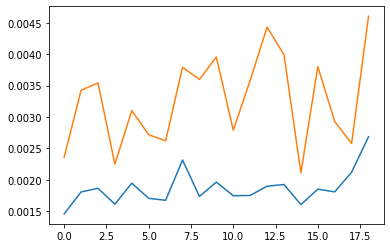

In [9]:
plt.plot(res[0:19])
plt.plot(res[19:19*2])
plt.show()